### SMA-EMA Strategy

<font color='orange'>
    EMA reacts more swiftly to prices changes than SMA and thus can capture the latest price trends, therefore if EMA crosses above SMA, then it is a signal to go long and vice versa. Usually, the window size for EMA and SMA are the same, but different sizes are also applicable.
</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
from scipy.optimize import brute
from datetime import datetime
from collections import namedtuple
import math
from numbers import Real
import jdc
plt.style.use("seaborn-v0_8")

> #### Implementation:

In [2]:
class SMAEMA:
    '''
    Description: 
        Class for the vectorized backtesting of SMAEMA-based trading strategies.

    Properties:
    ===========
    symbol: str
        ticker symbol
    sma: int
        time window in days for SMA
    ema: int
        time window in days for EMA
    start_date: str or datetime
        start date for data retrieval
    end_date: str or datetime
        end date for data retrieval
    tc: Real
        proportional transaction costs per trade

    Methods:
    ========
    load_data:
        retrieve and prepare data given a file path
    prepare_data:
        prepare data
    run_strategy:
        run the backtest for the SMA-EMA strategy
    run_with_updated_params:
        update SMA-EMA parameters and rerun SMA-EMA strategy
    optimize_params:
        implement a brute force optimization to search for optimal SMA-EMA parameters
    plot_result:
        plot the performance of the SMA-EMA strategy compared to buy-and-hold strategy
    '''
    def __init__(self, symbol, sma, ema, start_date, end_date, tc):
        if isinstance(symbol, str):
            self._symbol = symbol
        else:
            raise ValueError('Symbol must be a string.')
            
        if isinstance(sma, int):
            self._sma = sma
        else:
            raise ValueError('Sma must be an integer.')

        if isinstance(ema, int):
            self._ema = ema
        else:
            raise ValueError('Ema must be an integer.')
        
        if isinstance(start_date, str):
            self._start_date = start_date 
        elif isinstance(start_date, datetime):
            self._start_date = start_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('Start_date must be a string or a datetime object.')

        if isinstance(end_date, str):
            self._end_date = end_date 
        elif isinstance(end_date, datetime):
            self._end_date = end_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('End_date must be a string or a datetime object.')

        if isinstance(tc, Real):
            self._tc = tc
        else:
            raise ValueError('Trading_cost must be a real number.')
            
        self.data = None
        self.path = None
        self.result = None
        self.perf = None

    def __repr__(self):
        return f'SMAEMABackTester(symbol: {self.symbol}, sma: {self.sma}, ema: {self.ema}, start_date: {self.start_date}, end_date: {self.end_date})'
    
    # Symbol
    @property
    def symbol(self):
        return self._symbol
    @symbol.setter
    def symbol(self, symbol):
        if isinstance(symbol, str):
            self._symbol = symbol
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Symbol must be a string.')

    # Sma
    @property
    def sma(self):
        return self._sma
    @sma.setter
    def sma(self, sma):
        if isinstance(sma, int):
            self._sma = sma
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Sma must be an integer.')

    # Ema
    @property
    def ema(self):
        return self._ema
    @ema.setter
    def ema(self, ema):
        if isinstance(ema, int):
            self._ema = ema
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Ema must be an integer.')

    # Start_date
    @property
    def start_date(self):
        return self._start_date
    @start_date.setter
    def start_date(self, start_date):
        if isinstance(start_date, str):
            self._start_date = start_date 
        elif isinstance(start_date, datetime):
            self._start_date = start_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('Start_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    # End_date
    @property
    def end_date(self):
        return self._end_date
    @end_date.setter
    def end_date(self, end_date):
        if isinstance(end_date, str):
            self._end_date = end_date 
        elif isinstance(end_date, datetime):
            self._end_date = end_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('End_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    @property
    def tc(self):
        return self._tc
    @tc.setter
    def tc(self, tc):
        if isinstance(tc, Real):
            self._tc = tc
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Trading_cost must be a real number.')

In [3]:
%%add_to SMAEMA
def load_data(self, path):
    '''
    Retrieve and prepare the data given a file path.
    '''
    if isinstance(path, str):
        self.path = path
    else:
        raise ValueError('File path of data must be a string.')
    self.prepare_data()

In [4]:
%%add_to SMAEMA
def prepare_data(self):
    '''
    Prepare data.
    '''
    # Load data
    self.data = pd.read_csv(self.path, parse_dates=['Date'], index_col='Date')
    # Filter data for given symbol
    self.data = self.data[self.symbol].to_frame().dropna()
    # Filter data for given period
    self.data = self.data.loc[self.start_date : self.end_date].copy()
    self.data.rename(columns={self.symbol: 'Price'}, inplace=True)
    
    # sma
    self.data['SMA'] = self.data['Price'].rolling(self.sma).mean() 
    # ema
    self.data['EMA'] = self.data['Price'].ewm(span=self.ema, min_periods=self.ema).mean()
    
    # Return of buy-and-hold strategy
    return_buy_and_hold = self.data['Price'] / self.data['Price'].shift(1)
    # Return (log) of buy-and-hold strategy
    self.data['Return_Buy_Hold(log)'] = np.log(return_buy_and_hold)
    # Cumulative return of buy-and-hold strategy
    self.data['Return_Buy_Hold(cum)'] = self.data['Return_Buy_Hold(log)'].cumsum().apply(np.exp)

In [5]:
%%add_to SMAEMA
def run_strategy(self):
    '''
    Backtest the SMAEMA strategy.
    '''
    data = self.data.copy().dropna()
    # If ema > sma, hold long position and otherwise short
    data['Position'] = np.where(data['EMA'] > data['SMA'], 1, -1)
    # Number of trades
    data['Trades'] = data['Position'].diff().fillna(0).abs()
    
    # Return of sma-ema strategy (position of previous day * return of current day)
    data['Return_SMAEMA(log)'] = data['Position'].shift(1) * data['Return_Buy_Hold(log)']
    data.dropna(inplace=True)
    # Return of ema strategy (excluding trading cost)
    data['Return_SMAEMA_Net(log)'] = data['Return_SMAEMA(log)'] - data['Trades'] * self.tc
    
    # Cumulative return of sma-ema strategy
    data['Return_SMAEMA(cum)'] = data['Return_SMAEMA(log)'].cumsum().apply(np.exp)
    # Cumulative return of sma-ema strategy (excluding trading cost)
    data['Return_SMAEMA_Net(cum)'] = data['Return_SMAEMA_Net(log)'].cumsum().apply(np.exp)
    self.result = data

    abs_perf = self.result['Return_SMAEMA(cum)'].iloc[-1]
    out_perf = abs_perf - data['Return_Buy_Hold(cum)'].iloc[-1]

    self.perf = namedtuple('sma_ema_performance', ['sma_ema_abs_performance', 'sma_ema_out_performance'])
    self.perf.sma_ema_abs_performance = round(abs_perf, 6)
    self.perf.sma_ema_out_performance = round(out_perf, 6)
    return self.perf.sma_ema_abs_performance

In [6]:
%%add_to SMAEMA
def run_with_updated_params(self, sma_ema):
    '''
    Update SMAEMA parameters and rerun SMAEMA strategy.

    Parameters:
    ===========
    ema: tuple
        ema parameter tuple
    '''
    self.sma = int(sma_ema[0])
    self.ema = int(sma_ema[1])
    return -self.run_strategy()

In [7]:
%%add_to SMAEMA
def optimize_params(self, sma_range, ema_range):
    '''
    Find optimal sma and ema combination in terms of best possible SMAEMA return.
    
    Parameters:
    ===========
    sma_range, ema_range: tuple
        smaema ranges tuples      
    '''
    opt = brute(self.run_with_updated_params, ranges=(sma_range, ema_range), finish=None)
    return opt

In [8]:
%%add_to SMAEMA
def plot_result(self):
    '''
    Plots the cumulative performance of the SMAEMA strategy comparing to buy-and-hold.
    '''
    if self.result is None:
        print('No result for display, please run the strategy')
    else:
        title = f'{self.symbol} | SMA = {self.sma} | EMA = {self.ema} | TC = {self.tc}'
        self.result[['Return_Buy_Hold(cum)', 'Return_SMAEMA(cum)', 'Return_SMAEMA_Net(cum)']].plot(title=title, figsize=(12, 8))        

> #### Example:

In [9]:
PATH = './data/forex_pairs.csv'

SMA = 50
EMA = 50
SMA_RANGE = (20, 100, 1)
EMA_RANGE = (20, 100, 1)

SYMBOL = 'EURUSD=X'
START_DATE = '2004-01-01'
END_DATE = '2020-06-30'
TRADING_COST = 0.00007

In [10]:
smaema = SMAEMA(symbol=SYMBOL, 
                sma=SMA, 
                ema=EMA,
                start_date=START_DATE,
                end_date=END_DATE,
                tc=TRADING_COST)
smaema

SMAEMABackTester(symbol: EURUSD=X, sma: 50, ema: 50, start_date: 2004-01-01, end_date: 2020-06-30)

In [11]:
smaema.load_data(path = PATH)
smaema.data.head()

,Price,SMA,EMA,Return_Buy_Hold(log),Return_Buy_Hold(cum)
Date,,,,,
2004-01-01,1.258194,NaN,NaN,NaN,NaN
2004-01-02,1.258194,NaN,NaN,0.000000,1.000000
2004-01-05,1.268698,NaN,NaN,0.008313,1.008348
2004-01-06,1.272103,NaN,NaN,0.002681,1.011055
2004-01-07,1.264095,NaN,NaN,-0.006315,1.004690


In [12]:
smaema.run_strategy()
smaema.result.head()

,Price,SMA,EMA,Return_Buy_Hold(log),Return_Buy_Hold(cum),Position,Trades,Return_SMAEMA(log),Return_SMAEMA_Net(log),Return_SMAEMA(cum),Return_SMAEMA_Net(cum)
Date,,,,,,,,,,,
2004-03-11,1.235102,1.256829,1.251285,0.009686,0.981646,-1,0.0,-0.009686,-0.009686,0.990361,0.990361
2004-03-12,1.222404,1.256113,1.249991,-0.010334,0.971555,-1,0.0,0.010334,0.010334,1.000648,1.000648
2004-03-15,1.227205,1.255283,1.248975,0.003919,0.975370,-1,0.0,-0.003919,-0.003919,0.996734,0.996734
2004-03-16,1.226106,1.254363,1.247962,-0.000896,0.974497,-1,0.0,0.000896,0.000896,0.997627,0.997627
2004-03-17,1.222703,1.253535,1.246848,-0.002779,0.971792,-1,0.0,0.002779,0.002779,1.000404,1.000404


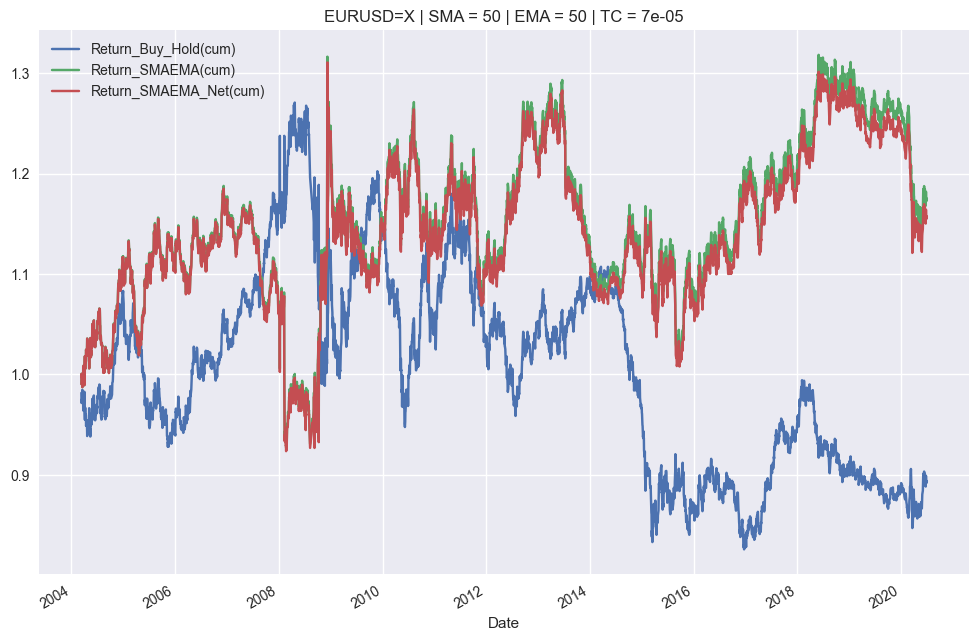

In [13]:
smaema.plot_result()

In [14]:
smaema.optimize_params(sma_range=SMA_RANGE, ema_range=EMA_RANGE)

array([43., 36.])